In [1]:
from huggingface_hub import snapshot_download

In [2]:
model_dir = snapshot_download(repo_id="MONAI/wholeBody_ct_segmentation", local_dir="../models/monai_seg")
print("📥 Model pobrany do:", model_dir)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

📥 Model pobrany do: /home/mateusz/PW/INZ/vertabrae_cls/models/monai_seg


In [3]:
import os
import torch
from monai.bundle import ConfigParser

# Ścieżka do katalogu z pobranym modelem MONAI Bundle
model_dir = "../models/monai_seg"
model_file = "models/model.pt"  # zakładamy, że w folderze models jest plik model.pt

# Wczytanie konfiguracji inferencji z bundle (określa m.in. architekturę sieci i transformacje)
config_path = os.path.join(model_dir, "configs", "inference.json")
parser = ConfigParser()
parser.read_config(config_path)

# Utworzenie modelu zgodnie z konfiguracją (znalezienie definicji sieci w configu)
model = parser.get_parsed_content("network_def")
# Załadowanie wag modelu
weights = torch.load(os.path.join(model_dir, model_file), map_location="cpu")
# Jeśli wagi są zapisane pod kluczem "state_dict", wyciągnij go:
if isinstance(weights, dict) and "state_dict" in weights:
    weights = weights["state_dict"]
model.load_state_dict(weights)
model.eval()


SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

In [4]:
param_size = 0
for param in model.parameters():
    param_size += param.numel() * param.element_size()
print("Rozmiar modelu:", param_size / 1024 / 1024, "MB")

Rozmiar modelu: 71.71402359008789 MB


In [5]:
import os
import SimpleITK as sitk
import numpy as np
import torch  # lub import tensorflow as tf

def load_dicom_series_with_metadata(dicom_dir):
    """
    Wczytuje serię DICOM z folderu, zwraca tensor, opis serii oraz metadane.
    """
    # Znajdź wszystkie pliki DICOM w folderze
    reader = sitk.ImageSeriesReader()
    dicom_series = reader.GetGDCMSeriesFileNames(dicom_dir)
    if not dicom_series:
        raise ValueError(f"Nie znaleziono serii DICOM w folderze: {dicom_dir}")
    reader.SetFileNames(dicom_series)

    # Wczytaj serię DICOM jako obraz 3D
    image = reader.Execute()

    # Przekształć na NumPy array
    image_array = sitk.GetArrayFromImage(image)  # Shape: (z, y, x)

    # Konwersja na tensor (PyTorch)
    tensor = torch.tensor(image_array, dtype=torch.float32)  # Shape: (z, y, x)

    # Pobierz metadane z obrazu
    spacing = image.GetSpacing()  # Rozdzielczość voxelowa (x, y, z)
    direction = image.GetDirection()  # Orientacja
    origin = image.GetOrigin()  # Początek układu współrzędnych

    # Pobierz opis serii z pierwszego pliku
    first_file = dicom_series[0]
    file_reader = sitk.ImageFileReader()
    file_reader.SetFileName(first_file)
    file_reader.ReadImageInformation()
    series_description = file_reader.GetMetaData("0008|103e") if file_reader.HasMetaDataKey("0008|103e") else "Unknown"

    # Zwróć tensor, opis serii i metadane
    metadata = {
        "spacing": spacing,
        "direction": direction,
        "origin": origin
    }
    return tensor, series_description, metadata

# Przykład użycia
dicom_root_folder = "/media/mateusz/DATA/downloads/inz/RM M 40"
series_tensors = {}

for root, dirs, files in os.walk(dicom_root_folder):
    if files:  # Jeśli folder zawiera pliki
        try:
            tensor, series_description, metadata = load_dicom_series_with_metadata(root)
            series_tensors[series_description] = {"tensor": tensor, "metadata": metadata}
            print(f"Wczytano tensor o kształcie: {tensor.shape} dla serii: {series_description} z folderu: {root}")
            print(f"Metadane: {metadata}")
        except Exception as e:
            print(f"Błąd wczytywania DICOM z folderu {root}: {e}")

# Wybierz tensor zgodnie z priorytetami
selected_tensor = None
selected_description = None
selected_metadata = None

# 1. Szukaj serii "kosci"
for series_description, data in series_tensors.items():
    if "szyjny kosci" in series_description.lower():
        selected_tensor = data["tensor"]
        selected_metadata = data["metadata"]
        selected_description = series_description
        print(f"Wybrano tensor dla serii: {series_description} (priorytet: kosci)")
        break

# 2. Jeśli nie znaleziono "kosci", szukaj "miekkie"
if selected_tensor is None:
    for series_description, data in series_tensors.items():
        if "miekkie" in series_description.lower():
            selected_tensor = data["tensor"]
            selected_metadata = data["metadata"]
            selected_description = series_description
            print(f"Wybrano tensor dla serii: {series_description} (priorytet: miekkie)")
            break

# 3. Jeśli nie znaleziono "kosci" ani "miekkie", wybierz największy tensor
if selected_tensor is None:
    max_size = 0
    for series_description, data in series_tensors.items():
        tensor_size = data["tensor"].numel()  # Liczba elementów w tensorze
        if tensor_size > max_size:
            max_size = tensor_size
            selected_tensor = data["tensor"]
            selected_metadata = data["metadata"]
            selected_description = series_description
    if selected_tensor is not None:
        print(f"Wybrano największy tensor dla serii: {selected_description} (rozmiar: {max_size})")

# Sprawdź, czy wybrano tensor
if selected_tensor is None:
    print("Nie znaleziono odpowiedniego tensora.")
else:
    print(f"Kształt wybranego tensora: {selected_tensor.shape}")
    print(f"Metadane wybranego tensora: {selected_metadata}")

Błąd wczytywania DICOM z folderu /media/mateusz/DATA/downloads/inz/RM M 40: Nie znaleziono serii DICOM w folderze: /media/mateusz/DATA/downloads/inz/RM M 40
Wczytano tensor o kształcie: torch.Size([2, 1228, 512]) dla serii:  z folderu: /media/mateusz/DATA/downloads/inz/RM M 40/S1000
Metadane: {'spacing': (0.9765625, 0.9765625, 353.5533905932738), 'direction': (0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0), 'origin': (0.0, -160.0, 1199.31875)}


GDCMSeriesFileNames (0x624aca182650): No Series can be found, make sure your restrictions are not too strong



Wczytano tensor o kształcie: torch.Size([249, 512, 512]) dla serii: GLOWA PRZEGLAD, iDose (4)  z folderu: /media/mateusz/DATA/downloads/inz/RM M 40/S2010
Metadane: {'spacing': (0.486328125, 0.486328125, 0.7499999999999996), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 'origin': (-109.56, -61.392, 974.61)}
Wczytano tensor o kształcie: torch.Size([374, 512, 512]) dla serii: GLOWA KOSCI, iDose (4) z folderu: /media/mateusz/DATA/downloads/inz/RM M 40/S2020
Metadane: {'spacing': (0.486328125, 0.486328125, 0.4999999999999997), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 'origin': (-109.56, -61.392, 974.36)}
Wczytano tensor o kształcie: torch.Size([411, 512, 512]) dla serii: SZYJNY KOSCI, iDose (4)  z folderu: /media/mateusz/DATA/downloads/inz/RM M 40/S2030
Metadane: {'spacing': (0.474609375, 0.474609375, 0.5), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 'origin': (-106.434, -71.595, 848.76)}
Wczytano tensor o kształcie: torch.Size([273, 512, 512

In [6]:
selected_tensor.shape

torch.Size([411, 512, 512])

In [7]:
from monai.transforms import ScaleIntensityRanged, Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, NormalizeIntensityd, EnsureTyped, ScaleIntensityd

# Definicja transformacji
transforms = Compose([
    LoadImaged(keys=["image"]),  # Ładowanie obrazu
    EnsureTyped(keys=["image"]),  # Konwersja na typ zgodny z PyTorch/NumPy
    EnsureChannelFirstd(keys=["image"]),  # Upewnienie się, że kanały są na pierwszej osi
    Orientationd(keys=["image"], axcodes="RAS"),  # Ustawienie orientacji na RAS
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),  # Resampling do zadanych wymiarów voxelowych
    NormalizeIntensityd(keys=["image"], nonzero=True),  # Normalizacja intensywności na podstawie wartości niezerowych
    ScaleIntensityd(keys=["image"], minv=-1.0, maxv=1.0)  # Skalowanie intensywności do zakresu [-1.0, 1.0]
])

In [8]:
def save_tensor_as_nrrd(tensor, file_path, metadata):
    """
    Zapisuje tensor jako plik NRRD z metadanymi.
    
    Args:
        tensor (torch.Tensor): Tensor do zapisania.
        file_path (str): Ścieżka do pliku wyjściowego (powinna kończyć się na .nrrd).
        metadata (dict): Metadane obrazu, zawierające klucze: 'spacing', 'direction', 'origin'.
    """
    # Konwersja tensora na NumPy array
    array = tensor.numpy()  # Shape: (z, y, x)
    
    # Konwersja NumPy array na SimpleITK Image
    image = sitk.GetImageFromArray(array)  # SimpleITK interpretuje dane jako (z, y, x)
    
    # Ustaw metadane
    if "spacing" in metadata:
        image.SetSpacing(metadata["spacing"])  # Rozdzielczość voxelowa (x, y, z)
    if "direction" in metadata:
        image.SetDirection(metadata["direction"])  # Orientacja
    if "origin" in metadata:
        image.SetOrigin(metadata["origin"])  # Początek układu współrzędnych
    
    # Zapis do pliku NRRD
    sitk.WriteImage(image, file_path)
    print(f"Tensor zapisany jako NRRD z metadanymi: {file_path}")

In [9]:
import tempfile

In [10]:
with tempfile.TemporaryDirectory() as temp_dir:
    temp_file = os.path.join(temp_dir, "output.nrrd")
    
    # Zapisz tensor jako plik NIfTI
    save_tensor_as_nrrd(selected_tensor, temp_file, selected_metadata)
    print(f"Tensor zapisany jako plik tymczasowy: {temp_file}")
    
    # Przygotuj dane wejściowe dla transformacji
    data = {"image": temp_file}
    
    # Zastosuj transformacje

    transformed_data = transforms(data)
    transformed_tensor = transformed_data["image"]


Tensor zapisany jako NRRD z metadanymi: /media/mateusz/DATA/tmp/tmph04vw1g_/output.nrrd
Tensor zapisany jako plik tymczasowy: /media/mateusz/DATA/tmp/tmph04vw1g_/output.nrrd


In [11]:
transformed_tensor.shape

torch.Size([1, 163, 163, 138])

In [12]:
input_tensor = transformed_tensor.unsqueeze(0).to("cpu")  # Dodaj wymiar wsadu

In [13]:
from monai.inferers import sliding_window_inference

model.eval().to("cpu")
with torch.no_grad():
    output = sliding_window_inference(
        inputs=input_tensor,
        roi_size=(96, 96, 96),  
        sw_batch_size=1,
        predictor=model,
        overlap=0.5,
        mode="gaussian"
    )

In [14]:
segmentation = output.argmax(dim=1).squeeze().cpu().numpy()  # shape: (D, H, W)

# Policz unikalne etykiety i ile ich jest
labels, counts = np.unique(segmentation, return_counts=True)

# Pokaż w formie słownika
label_counts = dict(zip(labels, counts))

# Posortowane i wypisane
for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
    print(f"Label {label:>2}: {count} voxeli")

Label  0: 3383701 voxeli
Label 50: 85584 voxeli
Label 15: 26625 voxeli
Label 13: 25004 voxeli
Label 85: 17594 voxeli
Label 101: 17285 voxeli
Label 100: 15126 voxeli
Label 87: 9231 voxeli
Label 33: 8267 voxeli
Label 34: 8199 voxeli
Label 32: 6330 voxeli
Label 35: 5832 voxeli
Label 40: 5786 voxeli
Label 43: 5176 voxeli
Label 86: 4897 voxeli
Label 36: 4609 voxeli
Label 84: 4388 voxeli
Label 37: 4370 voxeli
Label 38: 3820 voxeli
Label 41: 3613 voxeli
Label 39: 3297 voxeli
Label 42: 3059 voxeli
Label 71: 2578 voxeli
Label 59: 2493 voxeli
Label 70: 2108 voxeli
Label 58: 2011 voxeli
Label 72: 1933 voxeli
Label 60: 1757 voxeli
Label 73: 898 voxeli
Label 31: 530 voxeli
Label 61: 276 voxeli
Label 93: 100 voxeli
Label 83: 32 voxeli
Label 74: 8 voxeli
Label 28: 4 voxeli
Label 21: 1 voxeli


In [15]:
output.shape

torch.Size([1, 105, 163, 163, 138])

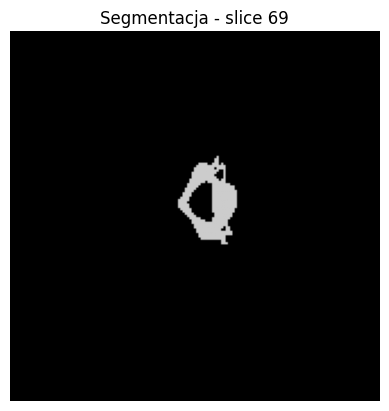

In [16]:
import matplotlib.pyplot as plt

# Załóżmy że output ma kształt (1, C, D, H, W)
output_np = output.argmax(dim=1).squeeze().cpu().numpy()  # (D, H, W)

z = output_np.shape[2] // 2  # środkowy slice

plt.imshow(output_np[:, :, z], cmap="nipy_spectral")
plt.title(f"Segmentacja - slice {z}")
plt.axis("off")
plt.show()

In [17]:
VERTEBRAE_MAP = {
    "L5": 18,
    "L4": 19,
    "L3": 20,
    "L2": 21,
    "L1": 22,
    "Th12": 23,
    "Th11": 24,
    "Th10": 25,
    "Th9": 26,
    "Th8": 27,
    "Th7": 28,
    "Th6": 29,
    "Th5": 30,
    "Th4": 31,
    "Th3": 32,
    "Th2": 33,
    "Th1": 34,
    "C7": 35,
    "C6": 36,
    "C5": 37,
    "C4": 38,
    "C3": 39,
    "C2": 40,
    "C1": 41,
}

In [22]:
target_vertebrae = "Th9"
target_size = (64, 64, 64)

In [23]:
target_label = VERTEBRAE_MAP.get(target_vertebrae)
if target_label is None:
    raise ValueError(f"Invalid target vertebrae: {target_vertebrae}")

labels = [target_label]
if target_size is None:
    labels.extend([max(18, target_label - 1), min(41, target_label + 1)])

mask = np.isin(segmentation, labels).astype(np.uint8)

coords = np.array(mask.nonzero())
if coords.shape[1] == 0:
    print("No vertebrae found in the segmentation.")

zmin, ymin, xmin = coords.min(axis=1)
zmax, ymax, xmax = coords.max(axis=1)


No vertebrae found in the segmentation.


ValueError: zero-size array to reduction operation minimum which has no identity

In [24]:
labels

[26]

In [ ]:
target_coords = np.array((coords.max(axis=1) + coords.min(axis=1)) // 2)
z_center, y_center, x_center = target_coords

z_half, y_half, x_half = [size // 2 for size in target_size]

z_start = z_center - z_half
y_start = y_center - y_half
x_start = x_center - x_half

z_end = z_start + target_size[0]
y_end = y_start + target_size[1]
x_end = x_start + target_size[2]

pad_z_start = max(0, -z_start)
pad_y_start = max(0, -y_start)
pad_x_start = max(0, -x_start)

pad_z_end = max(0, z_end - input_tensor.shape[2])
pad_y_end = max(0, y_end - input_tensor.shape[3])
pad_x_end = max(0, x_end - input_tensor.shape[4])

z_start = max(0, z_start)
y_start = max(0, y_start)
x_start = max(0, x_start)

z_end = min(input_tensor.shape[2], z_end)
y_end = min(input_tensor.shape[3], y_end)
x_end = min(input_tensor.shape[4], x_end)

cropped_tensor = input_tensor[:, :, z_start:z_end, y_start:y_end, x_start:x_end]

if any([pad_z_start, pad_y_start, pad_x_start, pad_z_end, pad_y_end, pad_x_end]):
    cropped_tensor = torch.nn.functional.pad(
        cropped_tensor,
        (pad_x_start, pad_x_end, pad_y_start, pad_y_end, pad_z_start, pad_z_end),
        mode="constant",
        value=0,
    )

output_tensor = cropped_tensor.detach().cpu()

In [ ]:
import matplotlib.pyplot as plt

mid = output_tensor.shape[2] // 2
plt.imshow(output_tensor[:, :, mid], cmap="gray")
plt.axis("off")
plt.show()

✅ Patch dla labelu 27 + sąsiadów: shape=torch.Size([11, 12, 11])


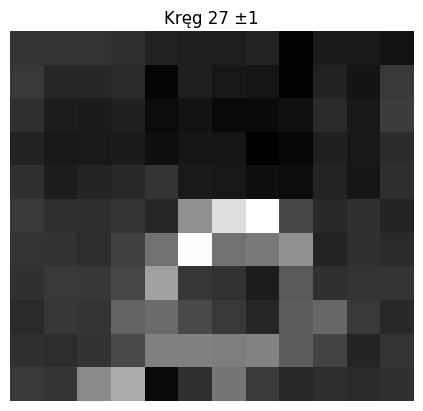

In [35]:
import matplotlib.pyplot as plt
import numpy as np

ordered_vertebra_labels = [
    41, 40, 39, 38, 37, 36, 35,  # C1–C7
    34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23,  # Th1–Th12
    22, 21, 20, 19, 18  # L1–L5
]

def extract_patch_with_neighbors(segmentation, input_tensor, center_label, margin=5, neighbor_range=1):
    try:
        center_index = ordered_vertebra_labels.index(center_label)
    except ValueError:
        print(f"❌ Label {center_label} not in vertebral list.")
        return None

    neighbor_labels = ordered_vertebra_labels[
        max(0, center_index - neighbor_range) : center_index + neighbor_range + 1
    ]

    # Maska dla danego kręgu i sąsiadów
    mask = np.isin(segmentation, neighbor_labels).astype(np.uint8)

    coords = np.array(mask.nonzero())
    if coords.shape[1] == 0:
        print("⚠️ Brak voxeli w masce łączonej.")
        return None

    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)

    zmin = max(zmin - margin, 0)
    ymin = max(ymin - margin, 0)
    xmin = max(xmin - margin, 0)
    zmax = min(zmax + margin, segmentation.shape[0])
    ymax = min(ymax + margin, segmentation.shape[1])
    xmax = min(xmax + margin, segmentation.shape[2])

    # Wytnij z input_tensor: (1, 1, D, H, W)
    patch = input_tensor[:, :, zmin:zmax, ymin:ymax, xmin:xmax]
    patch_tensor = patch.squeeze().detach().cpu()  # (D, H, W)

    print(f"✅ Patch dla labelu {center_label} + sąsiadów: shape={patch_tensor.shape}")

    # Wizualizacja slice Z
    mid = patch_tensor.shape[2] // 2
    plt.imshow(patch_tensor[:, :, mid], cmap="gray")
    plt.title(f"Kręg {center_label} ±{neighbor_range}")
    plt.axis("off")
    plt.show()

    return patch_tensor

# Przykład: vertebrae_L1 → label 22
patch_L1 = extract_patch_with_neighbors(segmentation, input_tensor, center_label=27)
